In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import torch.nn as nn
from tqdm import tqdm #for creating a progress bar during training loop
import random

In [3]:
#Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The network is made to discover wave functions of certain parity by defining the output in a way such that the wave functions of opposite parity, if discovered, add up to a trivial wave function i.e., 0. Said definitions are provided below:\
even --> $\mathcal{N}(\textbf{x}) + \mathcal{N}(-\textbf{x})$\
odd --> $\mathcal{N}(\textbf{x}) - \mathcal{N}(-\textbf{x})$\
\
The trial wave function is taken to be:\
$\Psi_{tr} = a + \textbf{B}(\textbf{x})\odot\mathcal{N}(\textbf{x})$\
where $a$ and $\textbf{B}$ are chosen to satisfy the boundary conditions and $\odot$ represents the element-wise product also known as Hadamard product or Schur product. The choice of $\textbf{B}$ also affects the convergence of the network. For the one-dimensional harmonic oscillator, one possible choice of $a$ and $\textbf{B}$ is:\
$a =0,\hspace{8pt}\textbf{B}(\textbf{x})=(1-e^{-(\textbf{x}-x_{min})})\odot(1-e^{(\textbf{x}-x_{max})})$ 

In [4]:
class SinAct(torch.nn.Module):
    """custom sine activation function"""
    @staticmethod
    def forward(input):
        return torch.sin(input)

class PINN1D(torch.nn.Module):
    
    """This network takes a x-point and energy E as input and returns a wavefunction psi-point.
    E is automatically initialized and is passed through a linear network before being fed as 
    input along with the x-point.

    The network is initialized to search for even wave functions. The parity is later flipped 
    during the training."""

    def __init__(self, D_hid: int):
        super(PINN1D,self).__init__()  
        self.actv     = SinAct()
        self.parity   = 'even'
        self.Lin_E    = torch.nn.Linear(1,1)
        self.Lin_1    = torch.nn.Linear(2, D_hid)
        self.Lin_out  = torch.nn.Linear(D_hid, 1)

    def forward(self,x_points,a):
        E_tr = self.Lin_E(torch.ones_like(x_points)) #t must have the shape [batch_size,1]
        E_tr = torch.abs(E_tr)
        l1_x = self.Lin_1(torch.cat((x_points,E_tr),1))
        l1_x_neg =self.Lin_1(torch.cat((-1*x_points,E_tr),1))
        sin_l1_x = self.actv(l1_x)
        sin_l1_x_neg = self.actv(l1_x_neg)

        if self.parity == 'even':
          out = self.Lin_out(sin_l1_x + sin_l1_x_neg)
        elif self.parity == 'odd':
          out = self.Lin_out(sin_l1_x - sin_l1_x_neg)

        # calculate wave function
        x_0 = torch.min(x_points)
        x_f = torch.max(x_points)
        B = (1-torch.exp(-(x_points-x_0)))*(1-torch.exp(x_points-x_f)) 
        psi_tr  = a + B*out

        return psi_tr, E_tr

In [5]:
def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """calculates derivatives"""
    df_value = output
    for j in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def PerturbPoints(x_points: torch.Tensor, sig=0.5) -> torch.Tensor:
    """Adds noise to x-points proportional to the spacing between them keeping the boudaries fixed"""
    x_0 = x_points[0]
    x_f = x_points[-1]
    delta_x = x_points[1] - x_points[0]
    noise = delta_x * torch.randn_like(x_points) * sig
    #noise = torch.normal(mean=mu, std=sig, size=x_points.shape)
    perturbed_x_points = x_points + noise
    perturbed_x_points[0] = x_0
    perturbed_x_points[-1] = x_f
    perturbed_x_points = torch.clamp(perturbed_x_points, min=x_0, max=x_f)
    perturbed_x_points.requires_grad = False
    return perturbed_x_points

def PermutePoints(x_points: torch.Tensor) -> torch.Tensor:
    """Permutes the coordinate points"""
    x_num = len(x_points)
    perm_indices = np.random.permutation(x_num)
    perm_x_points = x_points[perm_indices]
    #perm_x_points = perm_x_points.reshape(-1,1)
    perm_x_points.requires_grad = True
    return perm_x_points


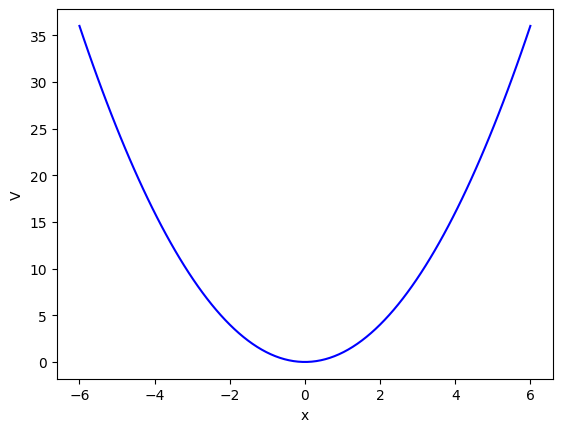

In [6]:
def Potential(x_points: torch.Tensor)-> torch.Tensor:
  omega = np.sqrt(2)
  return 0.5*omega**2*x_points**2

# plot the potential
xs = np.linspace(-6,6,100)
ys = Potential(torch.tensor(xs, dtype=torch.float64))
plt.plot(xs, ys, color='blue')
plt.xlabel('x')
plt.ylabel('V')
plt.show()

The differential equation loss, which can be called Schrödinger equation loss for our case, defined by \
	$\mathcal{L}_{DE}= Mean\left(\left[\frac{1}{2} \frac{d^2}{dx^2}\Psi_{tr} + \left(\textbf{E}_{tr}- V\right)\Psi_{tr}\right]^2\right)$\
allows incorporating Schrödinger equation directly into training the model.

In [7]:
def SELoss(x_points: torch.Tensor,psi: torch.Tensor, E: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
    psi_ddx= df(psi,x_points,2)
    se = 0.5*psi_ddx + (E-V)*psi
    l_se  = (se.pow(2)).mean()
    return l_se


$\mathcal{L}_{norm} = \left[\sqrt{\Psi_{tr}^T.\Psi_{tr}} - \frac{N}{x_{max}-x_{min}}\right]^2 $\
The norm loss prevents the network from converging to a trivial solution. However, It does not normalize the wave function and manual normalizations is perfomed only after the wavefunctions are obtained.

In [8]:
def NormLoss(x_points: torch.Tensor,psi: torch.Tensor) -> torch.Tensor:
    x_num = len(x_points)
    x_max = torch.max(x_points)
    x_min = torch.min(x_points)
    norm = torch.sqrt(torch.dot(psi[:, 0], psi[:, 0]))
    l_n = ((x_num / (x_max - x_min))- norm ).pow(2)
    return l_n


In [9]:
def weights_init(m):
    """reinitializes weights"""
    if isinstance(m, nn.Linear) and m.weight.shape[0] != 1:
        torch.nn.init.xavier_uniform(m.weight.data)

To obtain the excited states, the following orthogonality loss is penalized:\
$\mathcal{L}_{ortho}^k=\left(\sum_{j=0}^{k-1}(\Psi_{tr})_j^T.(\Psi_{tr})_k\right)$\
The $k$ indicates that the loss is for the $(k+1)^{th}$ wave function (not necessarily the $k^{th}$ excited state ) and $k$ wave functions have already been discovered

In [10]:

def Train(neurons_num: int, epochs_num: int, x_domain: list, x_num: int, a=0.0, lr=1e-2) -> tuple[dict, tuple, float]:
    pinn = PINN1D(neurons_num)
    pinn.to(device)
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(pinn.parameters(), lr=lr, betas=betas)

    #Empy lists for storing loss and enrgy histories
    total_loss_history = []
    se_loss_history = []
    nontriv_loss_history = []
    ortho_loss_history = []
    E_history = []

    # Dictionary to store the best performing networks
    di = (None, 1e+20)
    model_storage = {}
    for j in range(4):
        model_storage[j] = di

    oc = 0  # Ortho-counter

    x_points = torch.linspace(x_domain[0], x_domain[-1], x_num).reshape(-1, 1)

    t0 = time.time()

    with tqdm(total=epochs_num, desc="Training", ncols=150) as pbar:
        for epoch in range(epochs_num):
            x_perturbed = PerturbPoints(x_points)
            x_perm = PermutePoints(x_perturbed).to(device)
            psi, E = pinn(x_perm,a)
            E_history.append(E[0].data.tolist()[0])
            V = Potential(x_perm)
            se_loss = SELoss(x_perm, psi, E, V)
            se_loss_history.append(se_loss)
            total_loss = se_loss
            norm_loss = NormLoss(x_perm, psi)
            nontriv_loss_history.append(norm_loss)
            total_loss += norm_loss

            if epoch == 1.5e4:
                oc += 1
                pinn.apply(weights_init)
                
            elif epoch == 3.5e4:
                pinn.parity = 'odd'
                oc += 1

            elif epoch == 5.5e4:
                oc += 1
        
            # Orthogonality loss
            if oc == 1:
                model_oc0 = model_storage[0][0]
                psi_oc0, E_oc0 = model_oc0(x_perm,a)
                ortho_loss = torch.abs(torch.dot(psi_oc0[:, 0], psi[:, 0])) / 25
                ortho_loss_history.append(ortho_loss)
                total_loss += ortho_loss

            elif oc == 2:
                model_oc0 = model_storage[0][0]
                model_oc1 = model_storage[1][0]
                psi_oc0, E_oc0 = model_oc0(x_perm,a)
                psi_oc1, E_oc1 = model_oc1(x_perm,a)
                ortho_loss = torch.abs(torch.dot(psi_oc0[:, 0]+psi_oc1[:, 0], psi[:, 0]))/25
                ortho_loss_history.append(ortho_loss)
                total_loss += ortho_loss


            elif oc == 3:
                model_oc0 = model_storage[0][0]
                model_oc1 = model_storage[1][0]
                model_oc2 = model_storage[2][0]
                psi_oc0, E_oc0 = model_oc0(x_perm,a)
                psi_oc1, E_oc1 = model_oc1(x_perm,a)
                psi_oc2, E_oc2 = model_oc2(x_perm,a)
                ortho_loss = torch.abs(torch.dot(psi_oc0[:, 0] + psi_oc1[:, 0] + psi_oc2[:, 0], psi[:, 0])) / 25
                ortho_loss_history.append(ortho_loss)
                total_loss += ortho_loss

            # Optimization
            total_loss.backward(retain_graph=False)
            optimizer.step()
            optimizer.zero_grad()
            total_loss_history.append(total_loss)

            # Store the best model; the best is for which the SE loss is the least
            if se_loss < model_storage[oc][1]:
                model_storage[oc] = (copy.deepcopy(pinn), se_loss)

            # Update additional info every 100 epochs for the progress bar
            if epoch % 100 == 0:
                oc_info = f"oc: {oc}"
                loss_info = f"loss: {total_loss.item():.4f}"
                E_info = f"E: {E[0].item():.4f}"
                pbar.set_postfix_str(f"{oc_info} | {loss_info}| {E_info}")
            # Update tqdm progress bar
            pbar.update(1)

    tf = time.time()
    runTime = tf - t0
    loss_histories = (total_loss_history, se_loss_history, nontriv_loss_history, ortho_loss_history, E_history)
    return model_storage, loss_histories, runTime

In [11]:
#Train the model
neurons_num, epochs_num ,x_domain, x_num = 100,int(7.5e4), [-6,6], 600
model_storage, loss_histories, runTime=Train(neurons_num, epochs_num, x_domain, x_num)

Training:  16%|█████████▉                                                      | 11662/75000 [03:44<20:19, 51.92it/s, oc: 0 | loss: 0.0043| E: 0.7029]


KeyboardInterrupt: 

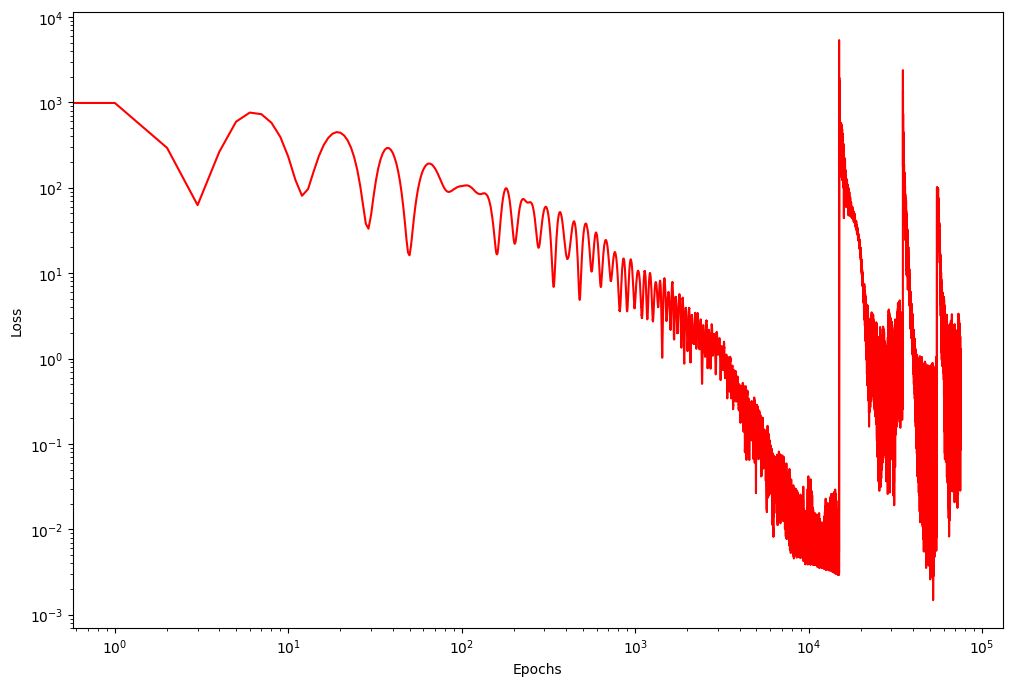

In [12]:
# plot the total loss

plt.figure(figsize = (12,8))
loss_hist =  [tensor.cpu().detach().numpy() for tensor in loss_histories[0]]
plt.loglog(loss_hist,color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

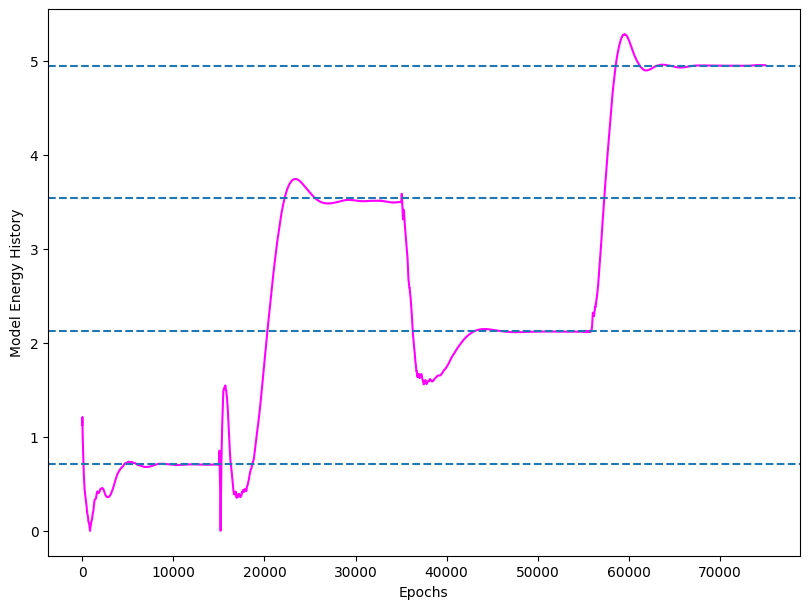

In [15]:
# plot the energy history

"""This plot marks the actual energy of the first four states with dotted lines.
Occasionaly the model jumps to the 4th excited state. """


plt.figure(figsize = (8,6))
plt.plot(loss_histories[-1],color='magenta')
plt.tight_layout()
plt.ylabel('Model Energy History')
plt.xlabel('Epochs')
plt.axhline(y=0.7071,linestyle='--')
plt.axhline(y=2.1213,linestyle='--')
plt.axhline(y=3.5355,linestyle='--')
plt.axhline(y=4.9497,linestyle='--')
plt.show()

Energy:  0.70546555519104
Energy:  3.507687568664551
Energy:  2.119553327560425
Energy:  4.945528030395508


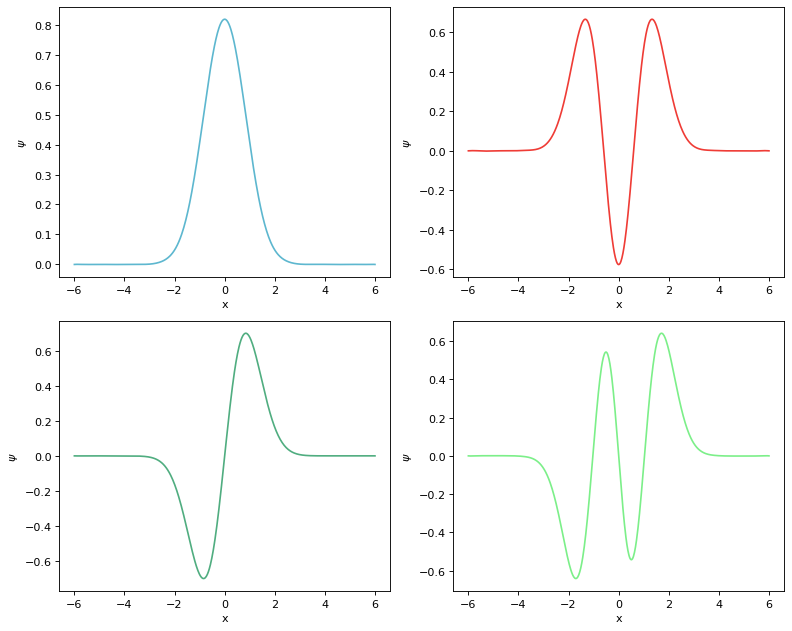

In [39]:
# plot the predicted wave function

x_num = 600
x = torch.linspace(-6,6,x_num)
xs = x.reshape(-1,1)
a = 0.0

# change oc for excited states; upto 3rd excited state
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=80)

for oc in range(4):
    model = model_storage[oc][0].cpu()
    psi, E = model(xs, a)
    print('Energy: ', E[0].item())
    psi = psi.data.numpy()

    # Normalize
    prod = np.dot(psi[:, 0], psi[:, 0])
    A = (x_num /(torch.max(xs)-torch.min(xs))) * (1 / prod)
    A = A.item()
    psi = psi * np.sqrt(A)

    if oc in [0, 2]:
        """The network sometimes produces a wave function flipped about
        x-axis. This does not affect the probablity density |psi|^2, """
        psi = -psi

    # plot
    random_color = (random.random(), random.random(), random.random())
    ax = axes[oc // 2, oc % 2]
    ax.plot(x, psi,color=random_color)
    ax.set_xlabel('x')
    ax.set_ylabel(r'$\psi$')

plt.tight_layout()
plt.show()
